We start with the Mid bracket for blitz games, being the most populuous dataset we have.

In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [3]:
chessdata = pd.read_csv('blitzMidRatingData.csv')
chessdata['Opening_new'].describe()

C:\Users\rinoa\AppData\Local\Temp\ipykernel_11996\1341046406.py:1: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  chessdata = pd.read_csv('blitzMidRatingData.csv')


count                35821
unique                  90
top       Sicilian Defense
freq                  5583
Name: Opening_new, dtype: object

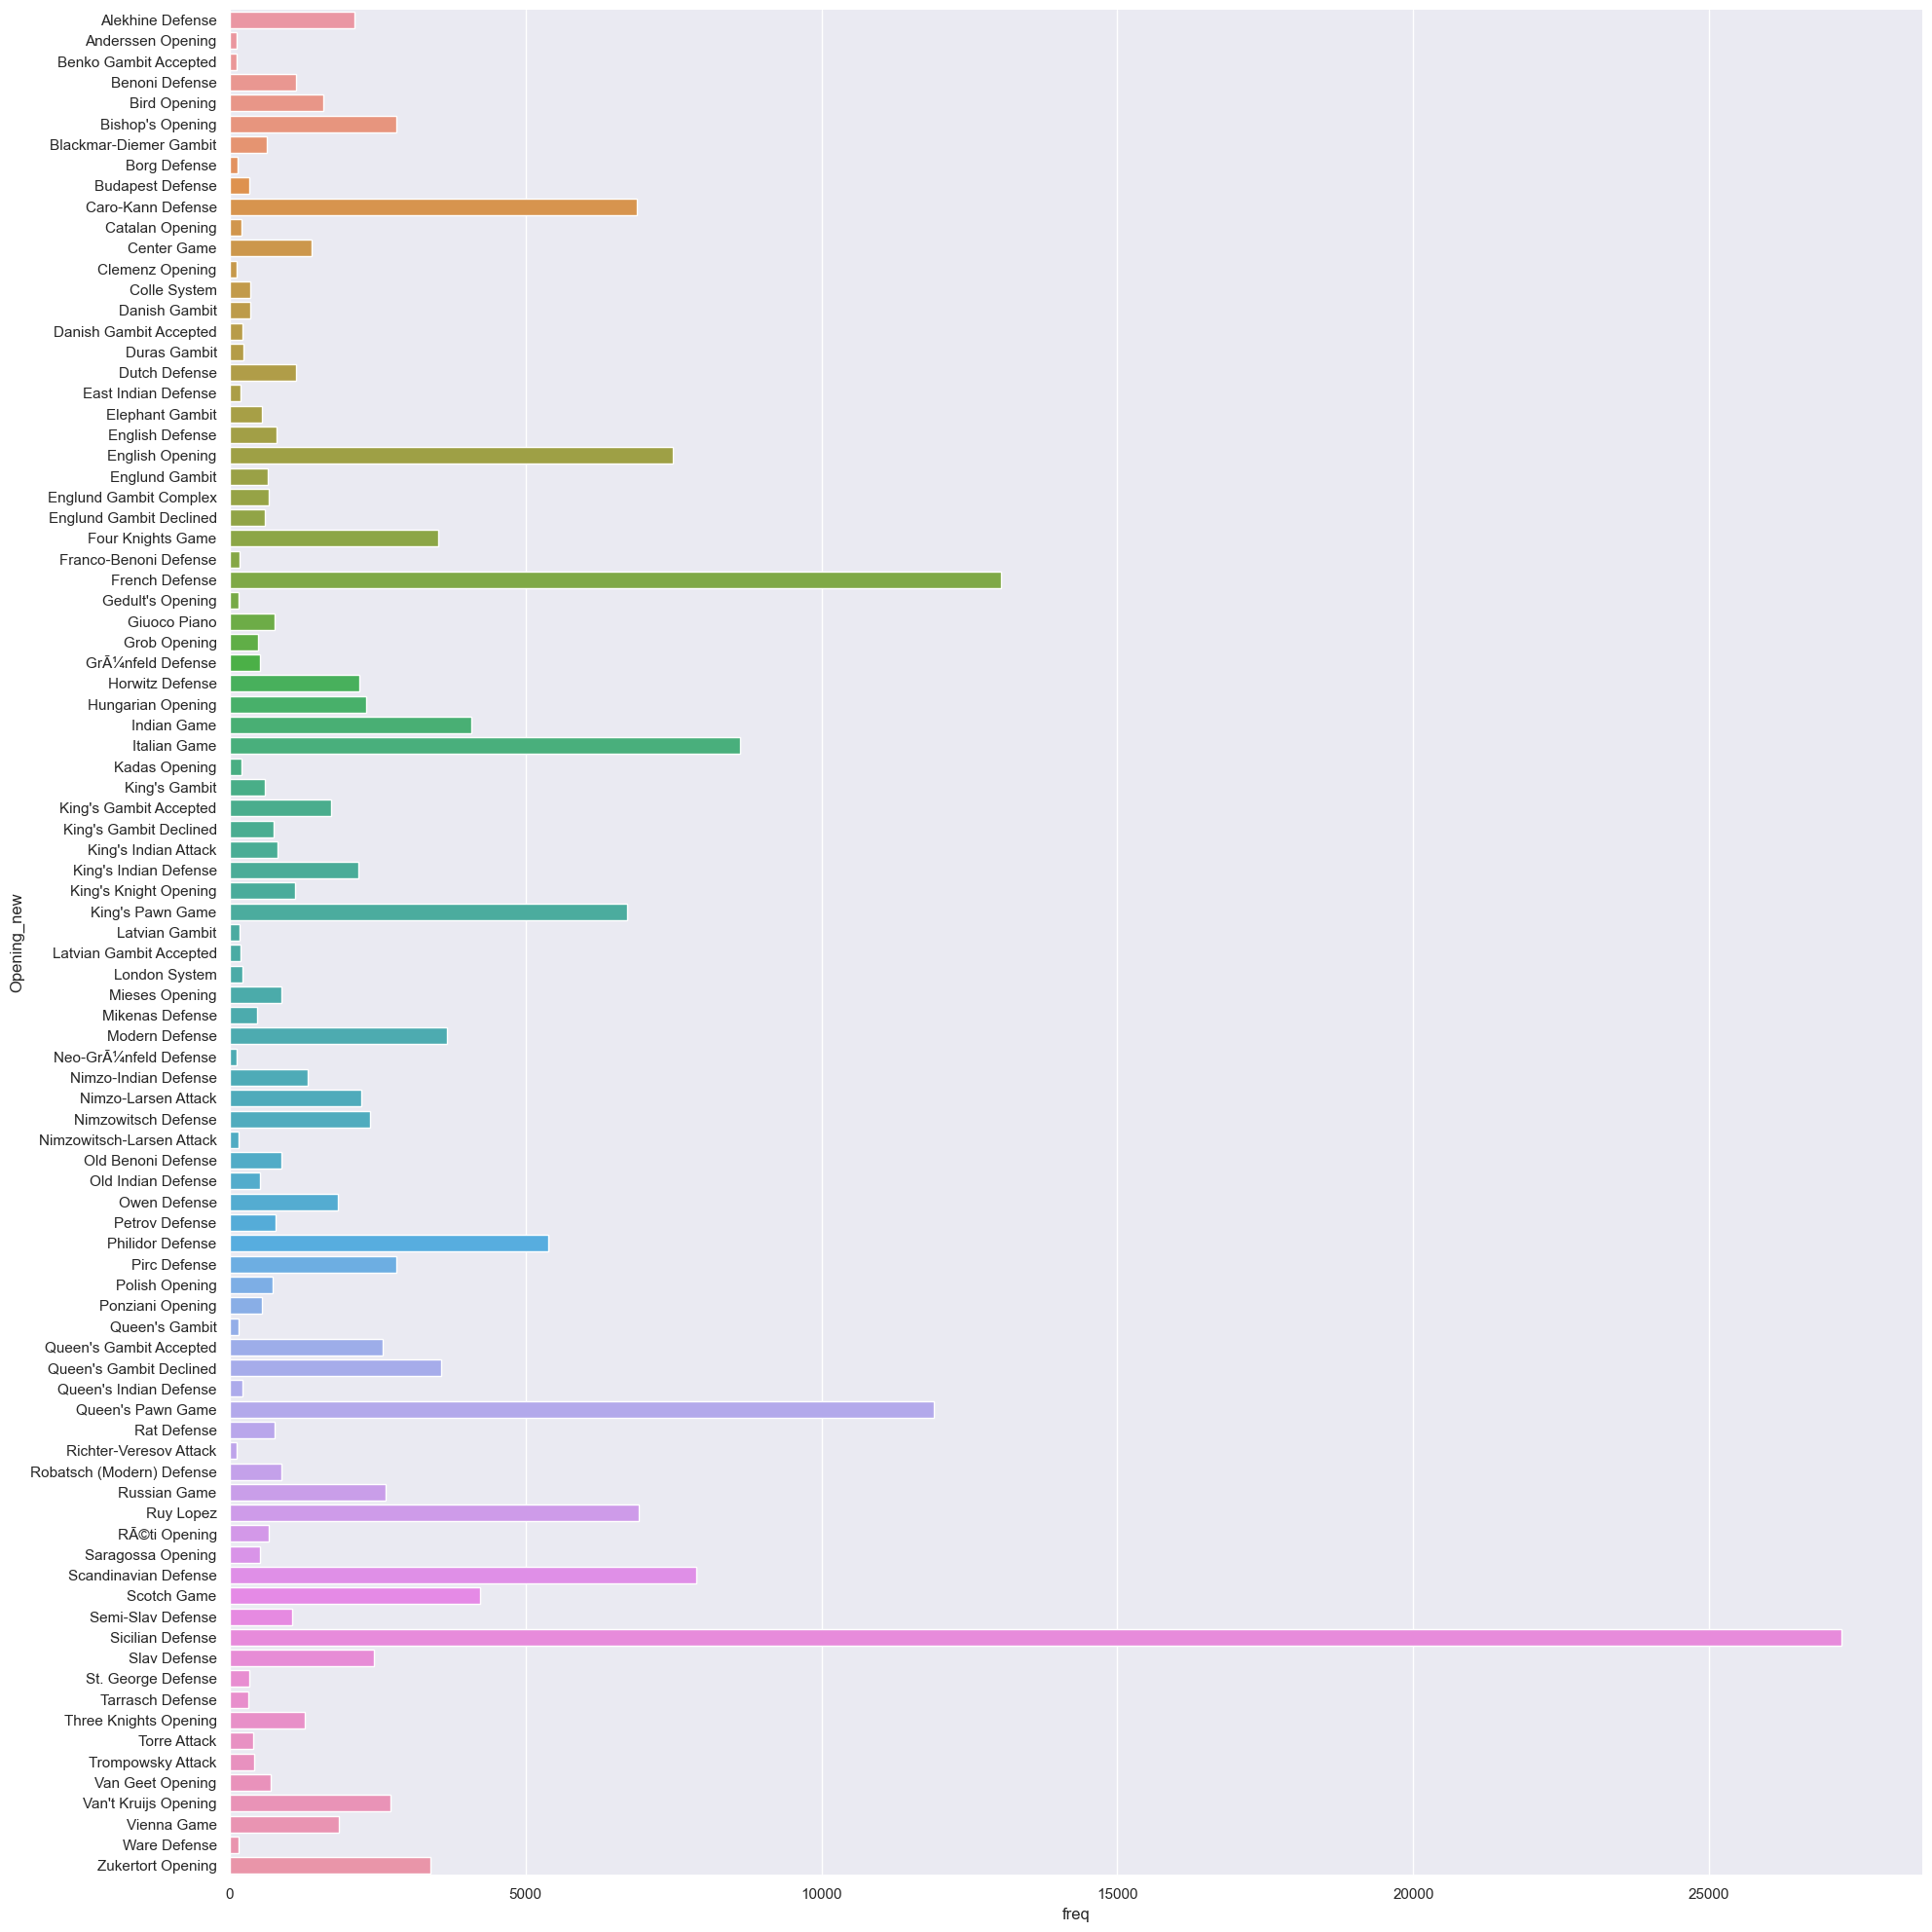

In [22]:
myorder=sorted(chessdata['Opening_new'].drop_duplicates())

sb.catplot(x= 'freq', y='Opening_new', data = chessdata, kind='bar',orient='h', height=20, aspect=1, order=myorder, errorbar=None)


The popularity of a game may also affect whether one may decide to play it, as it indicates the opponent is more willing to go into it as well, as forming the opening, unlike the rest of the game, is a somewhat coorperative game. So an opening with a disproportionately high winrate but extremely low play rate, while certainly advantageous, may not be as relevant as the opponent, knowing the openning being disadvantageous for them, would avoid it. We will see this effect more prominent in the competitive formats.

In [31]:
chessdata.loc[chessdata.Result == "0-1", 'Result'] = "-1" #black win
chessdata.loc[chessdata.Result == "1-0", 'Result'] = "1" #white win
chessdata.loc[chessdata.Result == "1/2-1/2", 'Result'] = "0" #draw
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
cat_predictors = chessdata[["Opening_new"]]

In [24]:
ohe.fit(cat_predictors)
predictors_cat_ohe = pd.DataFrame(ohe.transform(cat_predictors).toarray(), 
                                  columns=ohe.get_feature_names_out(cat_predictors.columns))

In [25]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

In [26]:
chessdata.info()
chessData_num = chessdata[['ELO Diff']]
chessData_res = chessdata['Result']
chessData_ohe = pd.concat([chessData_num, predictors_cat_ohe, chessData_res], 
                           sort = False, axis = 1).reindex(index=chessData_num.index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35821 entries, 0 to 35820
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    35821 non-null  int64  
 1   BlackElo      35821 non-null  int64  
 2   ECO           35821 non-null  object 
 3   Event         35821 non-null  object 
 4   Opening       35821 non-null  object 
 5   Result        35821 non-null  object 
 6   Termination   35821 non-null  object 
 7   TimeControl   35821 non-null  object 
 8   WhiteElo      35821 non-null  int64  
 9   BlackTitle    6 non-null      object 
 10  WhiteTitle    3 non-null      object 
 11  Move_ply_200  18 non-null     object 
 12  Category      35821 non-null  object 
 13  Opening_new   35821 non-null  object 
 14  freq          35821 non-null  int64  
 15  ELO Diff      35821 non-null  int64  
 16  Ave ELO       35821 non-null  float64
dtypes: float64(1), int64(5), object(11)
memory usage: 4.6+ MB


We start by finding the average winrate of each openning, for each side, to give us a gauge of what to look out for after accounting for player strength. We also dropped opennings that were played less than 100 times for the reasons highlighted above,as well as us not having enough information to say something representative at that point.

White:

In [4]:
freq_gen = chessdata
freq_gen['tot'] = freq_gen.groupby('Opening_new')['Opening_new'].transform('count')
temp = freq_gen[['Opening_new', 'Result', 'tot']]

#convert the fucking strings to integers
temp.loc[temp.Result == "0-1", 'Result'] = 0
temp.loc[temp.Result == "1-0", 'Result'] = 1
temp.loc[temp.Result == "1/2-1/2", 'Result'] = 0


temp['win'] = temp.groupby('Opening_new')['Result'].transform('sum')

temp['Opening_new'] = temp['Opening_new'].drop_duplicates()
temp = temp.dropna()

temp = temp.drop('Result', axis=1)
temp["win_rate"] = temp["win"].div(temp["tot"].values)

temp = temp[temp['tot'] >100]
temp.sort_values(by=['win_rate'])

C:\Users\rinoa\AppData\Local\Temp\ipykernel_11996\4158840191.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['win'] = temp.groupby('Opening_new')['Result'].transform('sum')
C:\Users\rinoa\AppData\Local\Temp\ipykernel_11996\4158840191.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Opening_new'] = temp['Opening_new'].drop_duplicates()


,Opening_new,tot,win,win_rate
112,Van't Kruijs Opening,395,152,0.38481
110,Bishop's Opening,527,213,0.404175
28,Hungarian Opening,332,144,0.433735
77,Polish Opening,141,62,0.439716
21,Indian Game,807,361,0.447336
24,Caro-Kann Defense,1339,599,0.447349
121,Alekhine Defense,277,125,0.451264
493,King's Gambit Declined,170,78,0.458824
36,Nimzo-Larsen Attack,350,162,0.462857
7,Four Knights Game,566,263,0.464664


To note, the Philidor Defense, which is both very popular and the most advantageous for white in this bracket.

The Englund Gambit and Rat Defense, while good for white, are rarely played even in this bracket as they give white a strong advantage. This is unlike the Queen's Gambit Accepted, which is both popular and strong for white. However, this opening, where white gives up(gambits) a pawn for central control, is not really considered a gambit despite its name as analysis shows that white is just better afterwards. We expect such openings to die in popularity in the higher bracket as black learns the best defense is just not to engage.



Black:

In [5]:
temp1 = freq_gen[['Opening_new', 'Result', 'tot']]

#convert the fucking strings to integers
temp1.loc[temp1.Result == "0-1", 'Result'] = 1
temp1.loc[temp1.Result == "1-0", 'Result'] = 0
temp1.loc[temp1.Result == "1/2-1/2", 'Result'] = 0


temp1['win'] = temp1.groupby('Opening_new')['Result'].transform('sum')

temp1['Opening_new'] = temp1['Opening_new'].drop_duplicates()
temp1 = temp1.dropna()

temp1 = temp1.drop('Result', axis=1)
temp1["win_rate"] = temp1["win"].div(temp1["tot"].values)

temp1.sort_values(by=['win_rate'])

temp1 = temp1[temp1['tot'] >100]
temp1.sort_values(by=['win_rate'])

C:\Users\rinoa\AppData\Local\Temp\ipykernel_11996\559534847.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1['win'] = temp1.groupby('Opening_new')['Result'].transform('sum')
C:\Users\rinoa\AppData\Local\Temp\ipykernel_11996\559534847.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1['Opening_new'] = temp1['Opening_new'].drop_duplicates()


,Opening_new,tot,win,win_rate
23,Philidor Defense,1065,369,0.346479
532,Englund Gambit Complex,133,51,0.383459
40,Queen's Gambit Accepted,585,226,0.386325
176,Horwitz Defense,378,148,0.391534
168,Old Indian Defense,107,42,0.392523
83,Rat Defense,150,59,0.393333
2,King's Indian Attack,110,46,0.418182
20,Queen's Gambit Declined,1461,613,0.419576
249,English Defense,161,68,0.42236
45,Slav Defense,508,216,0.425197


For black, the Caro-Kann and the Sicilian seem the most promising, with a positive win rate and a massive number of games played.

In [27]:


# Extract Response and Predictors
y = pd.DataFrame(chessData_ohe['Result'])
X = pd.DataFrame(chessData_ohe.drop('Result', axis = 1))


# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 8) 
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree


DecisionTreeClassifier(max_depth=8)

Train Data
Accuracy  :	 0.5512084230677196



<AxesSubplot: >

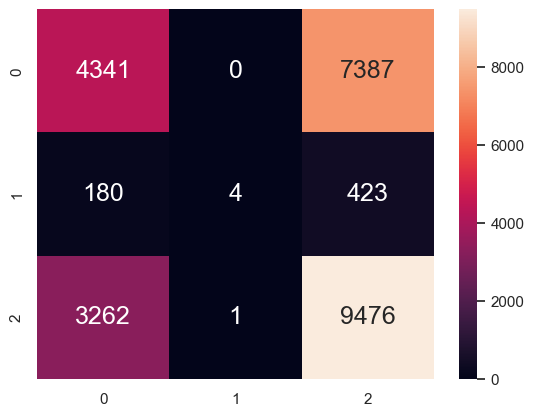

In [28]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
# tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
# fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
# tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
# fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

# print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
# print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
# print()

# print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
# print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.526286405508514



<AxesSubplot: >

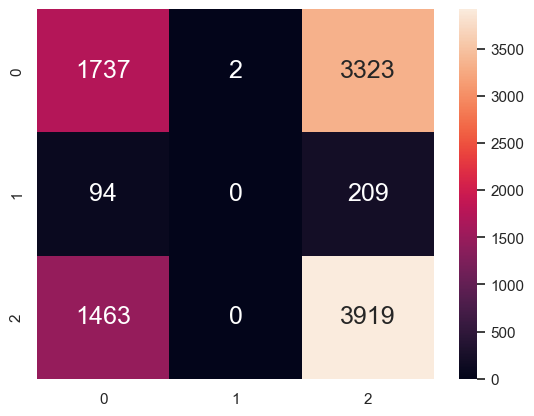

In [29]:
# Import the required metric from sklearn

# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
# tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
# fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
# tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
# fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

# print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
# print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
# print()

# print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
# print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

We include train and test accuracy to see reflective the tree is of actual data and decide that as long as we are within 3% points off, overfitting is not a big issue.

varying max depth, we find that the sweet spot for this dataset is about a depth of 8, any more and significant overfitting issues come into play. Though we also find that the data is rather fickle, though we have 3 categories to sort into, white, black and draw, draws are rare and hence taking them out, we find that we only do slightly above average in predicting who would win the match. This is regardless, expected as the players are matched according to their rank, which is an estimate on their relative strength, and though important, the openning only consists of the first few moves in a game, which may not be decisive as blunders during the midgame, which occur frequently in this rank would more likely influence the game. 

While the alg mostly sorts by the difference in player rank,(which, if anything, shows the accuracy of the rankings with respect to individual strength), it does make use of the  and type of openning lower in the tree.

[Text(0.47555051813471505, 0.9444444444444444, 'ELO Diff <= -33.5\ngini = 0.523\nsamples = 25074\nvalue = [11728, 607, 12739]\nclass = White'),
 Text(0.17778497409326424, 0.8333333333333334, 'ELO Diff <= -272.5\ngini = 0.516\nsamples = 6359\nvalue = [3469, 146, 2744]\nclass = Black'),
 Text(0.05958549222797927, 0.7222222222222222, 'Opening_new_French Defense <= 0.5\ngini = 0.424\nsamples = 536\nvalue = [379, 9, 148]\nclass = Black'),
 Text(0.03626943005181347, 0.6111111111111112, 'Opening_new_Hungarian Opening <= 0.5\ngini = 0.441\nsamples = 492\nvalue = [338, 9, 145]\nclass = Black'),
 Text(0.031088082901554404, 0.5, 'Opening_new_Nimzo-Indian Defense <= 0.5\ngini = 0.448\nsamples = 479\nvalue = [325, 9, 145]\nclass = Black'),
 Text(0.025906735751295335, 0.3888888888888889, 'Opening_new_Alekhine Defense <= 0.5\ngini = 0.446\nsamples = 477\nvalue = [325, 9, 143]\nclass = Black'),
 Text(0.015544041450777202, 0.2777777777777778, 'Opening_new_Owen Defense <= 0.5\ngini = 0.441\nsamples = 47

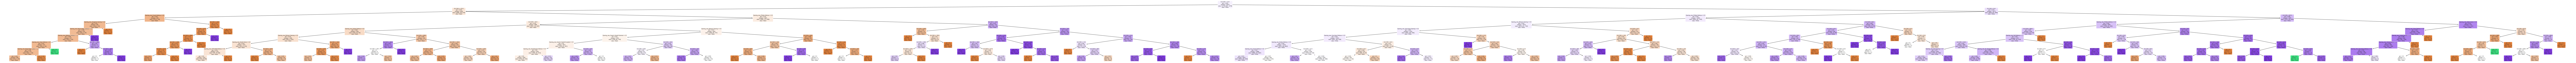

In [30]:
f = plt.figure(figsize=(256,6))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["Black","Draw","White"])

Naturally we are most interested in games where both sides are most evenly matched in ranking, which also happens to be most of the games due to the matching systems. So following the tree for ranking difference between -43.5 and 125, which contains 18231 games out of the 25074 games in this set, the alg decided to split the set based on whether the Philidor defence was on the board, in which of the 565 games played in this manner, white won 353 of them, a 62% win rate compared to white's average winrate in this of 52%. This is an increase of 10% in winrate, clearly there is something on here.

![The Philidor Defence](midphotos/Philidor_defence.png "Title")

![The Philidor Defence](midphotos/Philidor_MidBliz.png "Title")

Above is the Philidor defence.
From wikipedia:
"Today, the Philidor is known as a solid but passive choice for Black, and is seldom seen in top-level play except as an alternative to the heavily analysed openings that can ensue after the normal 2...Nc6. It is considered a good opening for amateur players who seek a defensive strategy that is simpler and easier to understand than the complex positions that result from an opening such as the French Defence."



Our data suggests otherwise though, that accounting for player strength, for players ranked in the middle, this defence dispropotionately favours white. We will see whether it holds for the other datasets.

The image: the resulting tree for the Philiodor defence with player strength accounted for, purple blocks indicate white's advantage, orange for black.

Another openning we are interested in is the Sicilian Defence. As one of the most well analysed and sturdiest defences for black, and the most popular openning of this dataset, we want to see how it holds up in this format. The Sicilian defence is a particularly interesting openning as white plays for control of the center of the board, as white should, moving their king's pawn up 2 squares, and black advances their c pawn, seeming suboptimal, as it yields the center to white. Despite black's letting white take the center, this is often thought to be one of the strongest defences for black.


Analysing the tree, we find that our alg has helpfully dedicated a subtree for the Sicilian Defence between players of ranking between 45 to 125 points. and between -43 and 45.

![The Philidor Defence](midphotos/Sicilian.png "Title")

![The Philidor Defence](midphotos/Sicilian_vs_others2.png "Title")

Above this the part of the tree dedicated to players ranking -43 to 45 around each other. So, this are players of about the same strength.  White has a 51% winrate in this format, and this is likely almost completely due to the first-move advantage. The tree first splits off Van 't Kruijs Opening, which out of the 14427 games, less than 200 were played. The data shows that this openning greatly favours black, which is no suprise as it just starts with white playing a sub-optimal move.

Regardless, we see the very next decision made is the Sicilian, of which 2332 games were played, and suddenly, black is very slightly favoured! This is not all, though, the alg also has a subtree detailing the Sicilian when white is significantly stronger than black.

![The Philidor Defence](midphotos/Sicilian_vs_others.png "Title")

Above is the part of the tree comparing the sicilian defense to some other defenses, for a ranking difference of 45 to 125 in white's favour. At the surface, it is a toss up, both sides win roughly the same in the sicilian. However, if we were to see the parent node in the tree, we see that that is from a dataset where white has an edge of almost 55%. Furthermore, these are exclusively games where white is ranked higher than black. So, just by playing the Sicilian, black completely removes white's innate advantage of the first move, and white's rating advantage, even in middle ranks. We will no doubt, have an oppotunity to come back to the Sicilian in another dataset, given its apparent strength and popularity.

To conclude, in this bracket, the Sicilian is the strongest for black regardless of strength of players and the Philidor is best for white for evenly matched players.